# Zonal Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from matplotlib import cm, colors

import pylandstats as pls

# let us use a custom colormap
custom_cmap = colors.ListedColormap([
    (0, 0, 0, 0),
    (0.6, 0, 0, 1),
    (.95, .9, .75, 1),
], N=3)

Landscapes tend to be heterogeneous and complex and therefore reducing such information to a single scalar value for all the landscape often leads to metric values that are hard to interpret. It might thus be helpful to decompose the landscape into a set of zones of interest and compute the metrics for each zone separatedly. Such approach to GIS is often referred to as zonal analysis. The PyLandStats library features three classes that might be used to that end: the more generic `ZonalAnalysis`, `BufferAnalysis` and `ZonalGridAnalysis`.

Consider the following landscape of the Canton of Vaud, Switzerland:

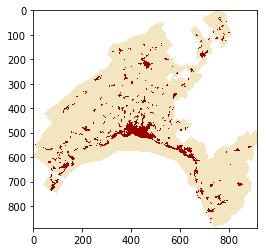

In [2]:
URBAN_CLASS_VAL = 1
input_filepath = '../data/clc/vaud_g100_clc00_V18_5.tif'

with rasterio.open(input_filepath) as src:
    plt.imshow(src.read(1), cmap=custom_cmap)

Red and cream pixels represent urban and natural land uses respectively. At the center of our Landscape stands a large urban patch, which corresponds to the agglomeration of Lausanne.

Landscape metrics are very sensitive to the spatial extent of the map. Therefore, when evaluating the landscape patterns of the agglomeration of Lausanne, the computed values for the metrics would strongly depend on how such agglomeration extent is defined. In order to overcome such issue, landscape studies often study how metrics vary for a set of spatial extents along the urban-rural gradient.

## Zonal analysis

The `ZonalAnalysis` class of PyLandStats serves to compute the landscape metrics over any set of zones, which are defined as NumPy boolean arrays of the same shape of the landscape of interest. For instance, in order to compute the metrics over a set of rectangular transects, let us define three transects of 300x200 cells (30x20km) that horizontally traverse our landscape at the latitude of Lausanne:

In [3]:
with rasterio.open(input_filepath) as src:
    base_mask_arr = np.full(src.shape,  False)

masks_arr = []
transect_len = 300
for transect_start in range(0, 900, transect_len):
    mask_arr = np.copy(base_mask_arr)
    mask_arr[400:600,transect_start:transect_start+transect_len] = True
    masks_arr.append(mask_arr)    

This is how the mask of each transect looks:

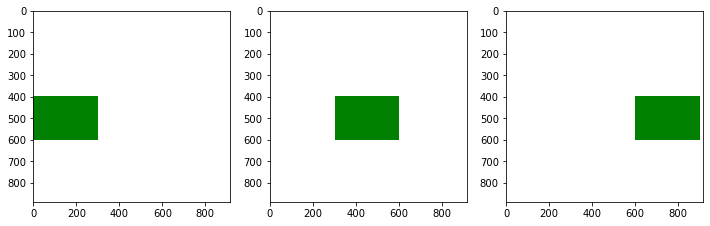

In [4]:
num_subplots = len(masks_arr)
fig = plt.figure(figsize=(num_subplots * 4, 4))
# better colormap to plot mask arrays
mask_cmap = plt.get_cmap('ocean_r')

for i in range(num_subplots):
    ax = fig.add_subplot(1, num_subplots, i + 1)
    ax.imshow(masks_arr[i], cmap=mask_cmap)

We will now use the `ZonalAnalysis` class with the list of mask arrays (corresponding to the transects) that we have constructed above. We can use the keyword argument `attribute_values` to map an identifying value or label to each of our landscapes. 

Here we will use strings that denote that each landscape corresponds to the transect from kilometers 0 to 30, 30 to 60 and 60 to 90 respectively. But we could have used any other list-like argument as long as it is consistent with the number of mask arrays provided through the `masks_arr` argument.

In [5]:
za = pls.ZonalAnalysis(input_filepath,
                       masks_arr=masks_arr,
                       attribute_values=['0-30', '30-60', '60-90'])

The `ZonalAnalysis` instance will automatically generate the three landscapes of interest (one for each transect) by masking the pixels of the input raster, which can be visualized by means of the `plot_landscapes` method as in:

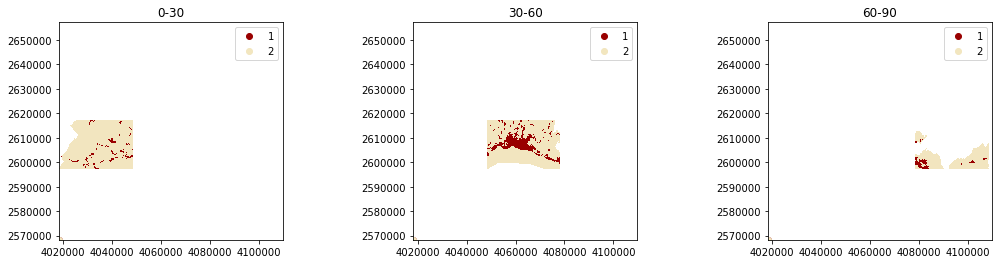

In [6]:
fig = za.plot_landscapes(cmap=custom_cmap)

And we can now compute and plot the landscape metrics for each of the transect landscapes.

Like `SpatioTemporalAnalysis`, `ZonalAnalysis` only supports class and landscape-level metrics, which again, can be computed by means of its methods `compute_class_metrics_df` and `compute_landscape_metrics_df` respectively, e.g.:

In [7]:
za.compute_class_metrics_df()

metric                     total_area proportion_of_landscape  \
class_val attribute_values                                      
1         0-30                   2641                  5.0768   
          30-60                  9577                 17.6965   
          60-90                  1761                 9.27281   
2         0-30                  49380                 94.9232   
          30-60                 44541                 82.3035   
          60-90                 17230                 90.7272   

metric                     number_of_patches patch_density  \
class_val attribute_values                                   
1         0-30                            37     0.0711251   
          30-60                           40     0.0739126   
          60-90                            9     0.0473909   
2         0-30                             2     0.0038446   
          30-60                            6     0.0110869   
          60-90                            6     0.0315939   

metric                     largest_patch_index total_edge edge_density  \
class_val attribute_values                                               
1         0-30                        0.707407     216700      4.16563   
          30-60                        12.2806     370500      6.84615   
          60-90                        6.90854      71900        3.786   
2         0-30                         94.9194     216700      4.16563   
          30-60                        81.8859     370500      6.84615   
          60-90                        53.2199      71900        3.786   

metric                     landscape_shape_index effective_mesh_size  area_mn  \
class_val attribute_values                                                      
1         0-30                           10.7961             7.81417  71.3784   
          30-60                          9.63776             831.455  239.425   
          60-90                          4.71429             92.9897  195.667   
2         0-30                           3.61124             46869.3    24690   
          30-60                          5.66194             36288.2   7423.5   
          60-90                          3.75665             6891.83  2871.67   

metric                      ... fractal_dimension_md fractal_dimension_ra  \
class_val attribute_values  ...                                             
1         0-30              ...              1.08715             0.162565   
          30-60             ...              1.08185             0.167805   
          60-90             ...              1.06691             0.129875   
2         0-30              ...              1.07006             0.116342   
          30-60             ...              1.05184             0.171006   
          60-90             ...              1.07797            0.0983169   

metric                     fractal_dimension_sd fractal_dimension_cv  \
class_val attribute_values                                             
1         0-30                        0.0425986              3.92986   
          30-60                       0.0370932              3.42972   
          60-90                       0.0424932               3.9649   
2         0-30                         0.058171              5.43621   
          30-60                       0.0593649              5.59432   
          60-90                       0.0329745              3.08267   

metric                     euclidean_nearest_neighbor_mn  \
class_val attribute_values                                 
1         0-30                                   743.825   
          30-60                                   685.22   
          60-90                                  1585.76   
2         0-30                                   223.607   
          30-60                                  279.945   
          60-90                                  594.107   

metric                     euclidean_nearest_neighbor_am  \
class

Likewise `SpatioTemporalAnalysis`, if we want to compute the metrics data frame only for a subset of metrics or classes, or customize how the metrics are computed, we must pass the arguments `metrics`, `classes` or `metrics_kws` to the `compute_class_metrics_df` and `compute_landscape_metrics_df`, as in:
<a id='customizing-zonal-analysis'></a>

In [8]:
metrics=['proportion_of_landscape', 'edge_density', 'fractal_dimension_am']
classes=[URBAN_CLASS_VAL]
metrics_kws={
    'proportion_of_landscape': {'percent': False },
    'edge_density': {'count_boundary': True}
}
za.compute_class_metrics_df(
    metrics=metrics, classes=[1], metrics_kws=metrics_kws)

metric                     proportion_of_landscape edge_density  \
class_val attribute_values                                        
1         0-30                            0.050768       4.2752   
          30-60                           0.176965      6.98104   
          60-90                          0.0927281       4.1704   

metric                     fractal_dimension_am  
class_val attribute_values                       
1         0-30                          1.10505  
          30-60                         1.14899  
          60-90                         1.11827

On the other hand, the `plot_metric` method of `ZonalAnalysis` will plot the value of a given metric for each of the buffered landscapes:

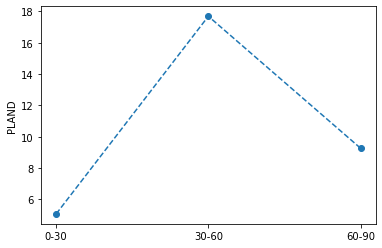

In [9]:
za.plot_metric('proportion_of_landscape', class_val=URBAN_CLASS_VAL)

Note that the values that we pass to `attribute_values` when initializing the `ZonalAnalysis` are used within the metric dataframes and plot labels.

In order to visualize such information in space, the zonal statistics can be computed in the form of a two-dimensional array with the `compute_zonal_statistics_arr` method as in:

In [10]:
zonal_statistics_arr = za.compute_zonal_statistics_arr(
    'proportion_of_landscape', class_val=URBAN_CLASS_VAL)

which returns an array of the same form as the input landscape.

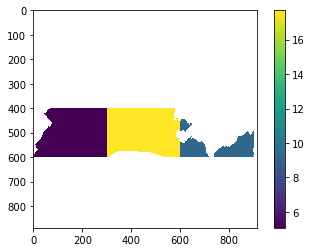

In [11]:
plt.imshow(zonal_statistics_arr)
plt.colorbar()

We can see that the highest proportion of urban land cover is found in the central transect, which actually corresponds to the most urbanized parts of Lausanne's agglomeration.

Finally, a zonal statistics array can be dumped into a GeoTiff raster file by means of the the `dst_filepath` argument of `compute_zonal_statistics_arr` as in:

In [12]:
_ = za.compute_zonal_statistics_arr('proportion_of_landscape',
                                    class_val=URBAN_CLASS_VAL,
                                    dst_filepath='pland-transects.tif')

## Buffer Analysis

In line with the classic concentric models of location and land use, we are often interested in evaluate how the landscape patterns change as we move away from the urban center. To that end, PyLandStats features the `BufferAnalysis` class (which inherits from the `ZonalAnalysis` class), which defines a series of spatial extents for our landscape based on buffers of increasing distances around our feature of interest - in this example, the agglomeration of Lausanne.

### From Point

We might define a given coordinate as the center of our region of interest (in this example, the center of Lausanne) and a series of buffer distances around that point:

In [13]:
from shapely.geometry import Point

# latitude and longitude of the center of Lausanne according to OpenStreetMap
base_mask = Point(6.6327025, 46.5218269)
base_mask_crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

# buffer distances (in meters)
buffer_dists = [10000, 15000, 20000]

then, we can use the `BufferAnalysis` class of Pylandstats as in (note that we need to provide the CRS of the geometry - in this example, the coordinate point):

In [14]:
ba = pls.BufferAnalysis(input_filepath,
                        base_mask,
                        buffer_dists,
                        base_mask_crs=base_mask_crs)

The `BufferAnalysis` instance will automatically generate the three landscapes of interest (one for each buffer distance) by masking the pixels of the input raster:

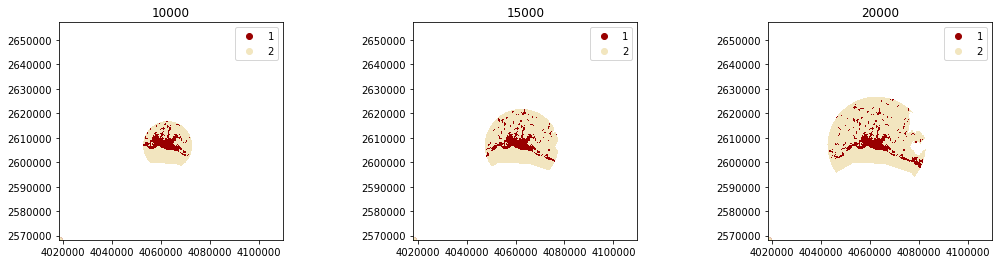

In [15]:
fig = ba.plot_landscapes(cmap=custom_cmap)

Likewise `ZonalAnalysis`, we can compute the landscap metrics for each buffer distance with the `compute_class_metrics_df` and `compute_landscape_metrics_df` methods, e.g.:

In [16]:
ba.compute_class_metrics_df()

metric                 total_area proportion_of_landscape number_of_patches  \
class_val buffer_dists                                                        
1         10000              7261                 24.9648                20   
          15000              9630                 16.7106                46   
          20000             12149                 13.3476                76   
2         10000             21824                 75.0352                 4   
          15000             47998                 83.2894                 4   
          20000             78871                 86.6524                 5   

metric                 patch_density largest_patch_index total_edge  \
class_val buffer_dists                                                
1         10000             0.068764             21.5472     223900   
          15000            0.0798223             11.5326     395200   
          20000            0.0834981             7.30169     565200   
2         10000            0.0137528             74.3614     223900   
          15000           0.00694107             82.9493     395200   
          20000            0.0054933             86.3151     565200   

metric                 edge_density landscape_shape_index effective_mesh_size  \
class_val buffer_dists                                                          
1         10000             7.69813               6.74269             1353.37   
          15000             6.85778               10.1472             774.307   
          20000             6.20962               12.9638              515.42   
2         10000             7.69813               4.96622             16083.7   
          15000             6.85778               5.79499             39651.8   
          20000             6.20962               6.63167               67813   

metric                  area_mn  ... fractal_dimension_md  \
class_val buffer_dists           ...                        
1         10000          363.05  ...              1.08318   
          15000         209.348  ...              1.07944   
          20000         159.855  ...              1.08242   
2         10000            5456  ...              1.06453   
          15000         11999.5  ...              1.06453   
          20000         15774.2  ...              1.08776   

metric                 fractal_dimension_ra fractal_dimension_sd  \
class_val buffer_dists                                             
1         10000                    0.163172            0.0434689   
          15000                    0.141302            0.0309886   
          20000                    0.167805            0.0344727   
2         10000                    0.134831            0.0538049   
          15000                    0.145607            0.0579905   
          20000                    0.170269            0.0585368   

metric                 fractal_dimension_cv euclidean_nearest_neighbor_mn  \
class_val buffer_dists                                                      
1         10000                      4.0267                       633.891   
          15000                     2.85544                       768.449   
          20000                     3.18956                       825.643   
2         10000                     4.98227                       211.803   
          15000                     5.35649                       223.607   
          20000                     5.40918                       229.443   

metric                 euclidean_nearest_neighbor_am  \
class_val buffer_dists                                 
1         10000                              278.966   
          15000                              348.027   
          20000                               386.53   
2         10000                              200.209   
          15000                              223.607   
          20000                               200.06   

metric                 euclidean_nearest_neighbor

Note that the data frames for `BufferAnalysis`, likewise those of `SpatioTemporalAnalysis` or `ZonalAnalysis` (see [above](#customizing-zonal-analysis)) can be customized via by passing the arguments `metrics`, `classes` or `metrics_kws` to the `compute_class_metrics_df` and `compute_landscape_metrics_df` methods.

The `plot_metric` method of `BufferAnalysis` will plot the value of a given metric for each of the buffered landscapes:

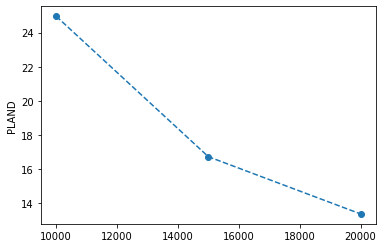

In [17]:
ba.plot_metric('proportion_of_landscape', class_val=URBAN_CLASS_VAL)

The specific plot above shows how the proportion of landscape (y-axis) occupied by urban land uses diminishes with the buffer distance (x-axis) around the feature of interest (i.e., the city center of Lausanne).

To examine more closely how landscape patterns change as we move along the urban-rural gradient, we might actually want to compute the metrics for each of the buffer rings that lie within each pair of increasing buffer distances. For instance, for the buffer distances considered in this example (i.e., 10000, 15000 and 20000), we would like to compute the metrics for the buffer rings that go from 0 to 10000m, 10000-15000m and 15000-20000m around the center of Lausanne).

To that end, we might pass the argument `buffer_rings=True` when instantiating `BufferAnalysis` as in:

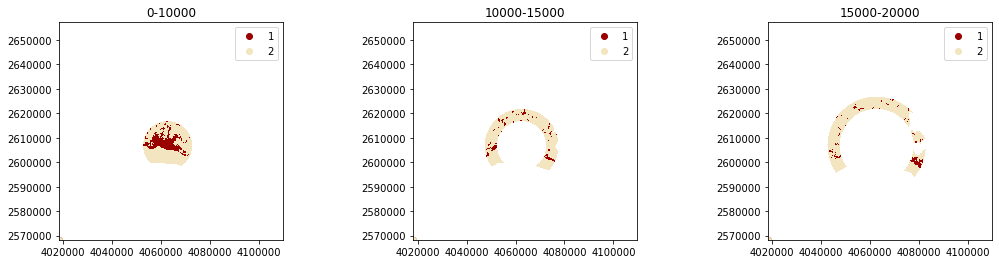

In [18]:
ba = pls.BufferAnalysis(input_filepath,
                        base_mask,
                        buffer_dists,
                        buffer_rings=True,
                        base_mask_crs=base_mask_crs)
fig = ba.plot_landscapes(cmap=custom_cmap)

In [19]:
ba.compute_class_metrics_df()

metric                 total_area proportion_of_landscape number_of_patches  \
class_val buffer_dists                                                        
1         0-10000            7261                 24.9648                20   
          10000-15000        2369                 8.29976                37   
          15000-20000        2519                 7.54372                37   
2         0-10000           21824                 75.0352                 4   
          10000-15000       26174                 91.7002                 3   
          15000-20000       30873                 92.4563                 8   

metric                 patch_density largest_patch_index total_edge  \
class_val buffer_dists                                                
1         0-10000           0.068764             21.5472     223900   
          10000-15000       0.129629             1.68518     168600   
          15000-20000       0.110805             3.11152     169100   
2         0-10000          0.0137528             74.3614     223900   
          10000-15000      0.0105105             83.6282     168600   
          15000-20000      0.0239578              76.117     169100   

metric                 edge_density landscape_shape_index effective_mesh_size  \
class_val buffer_dists                                                          
1         0-10000           7.69813               6.74269             1353.37   
          10000-15000       5.90688               9.14286             17.5131   
          15000-20000       5.06409                8.9901             36.1831   
2         0-10000           7.69813               4.96622             16083.7   
          10000-15000       5.90688               5.01543             20147.5   
          15000-20000       5.06409               5.48864             19637.6   

metric                  area_mn  ... fractal_dimension_md  \
class_val buffer_dists           ...                        
1         0-10000        363.05  ...              1.08318   
          10000-15000    64.027  ...              1.06999   
          15000-20000   68.0811  ...              1.07596   
2         0-10000          5456  ...              1.06453   
          10000-15000   8724.67  ...              1.04204   
          15000-20000   3859.12  ...              1.06587   

metric                 fractal_dimension_ra fractal_dimension_sd  \
class_val buffer_dists                                             
1         0-10000                  0.163172            0.0434689   
          10000-15000              0.123043             0.028939   
          15000-20000              0.141466            0.0357122   
2         0-10000                  0.134831            0.0538049   
          10000-15000              0.134779            0.0604809   
          15000-20000              0.136933            0.0443751   

metric                 fractal_dimension_cv euclidean_nearest_neighbor_mn  \
class_val buffer_dists                                                      
1         0-10000                    4.0267                       633.891   
          10000-15000               2.69333                       1016.19   
          15000-20000               3.33408                       933.734   
2         0-10000                   4.98227                       211.803   
          10000-15000               5.61286                       223.607   
          15000-20000               4.13596                       410.485   

metric                 euclidean_nearest_neighbor_am  \
class_val buffer_dists                                 
1         0-10000                            278.966   
          10000-15000                        650.064   
          15000-20000                        631.921   
2         0-10000                            200.209   
          10000-15000                        223.607   
          15000-20000                        1172.21   

metric                 euclidean_nearest_neighbor

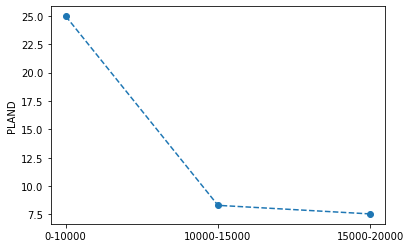

In [20]:
ba.plot_metric('proportion_of_landscape', class_val=URBAN_CLASS_VAL)

Again, the zonal statistics of a metric can be represented in space with of the `compute_zonal_statistics_arr` method:

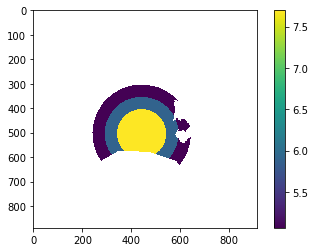

In [21]:
zonal_statistics_arr = ba.compute_zonal_statistics_arr(
    'edge_density', class_val=URBAN_CLASS_VAL)
plt.imshow(zonal_statistics_arr)
plt.colorbar()

and further dump it to a raster file by providing the `dst_filepath` argument.

### From Polygon

We might as well build our buffer zones from polygon geometries such as administrative boundaries

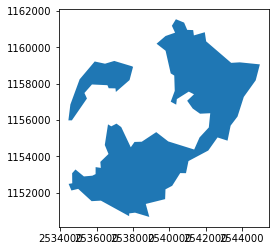

In [22]:
import geopandas as gpd

gdf = gpd.read_file('../data/gmb/g1a18.shp')
base_mask = gdf[gdf['GMDNAME'] == 'Lausanne']['geometry']
base_mask.plot()

Note that in this case, since we are working with a GeoSeries that has a CRS defined, we do not need to set it explicitly with the `base_mask_crs` argument.

In [23]:
base_mask.crs

{'init': 'epsg:2056'}

Also note that since in this case our base mask from which we will define buffer zones is already a polygon. Therefore, we might want to start from smaller buffer distances, even from zero, so that we start computing the metrics for the region defined by the polygon itself (in our example, the administrative boundaries)

In [24]:
buffer_dists = [0, 10000, 20000]

In [25]:
ba = pls.BufferAnalysis(input_filepath, base_mask, buffer_dists)

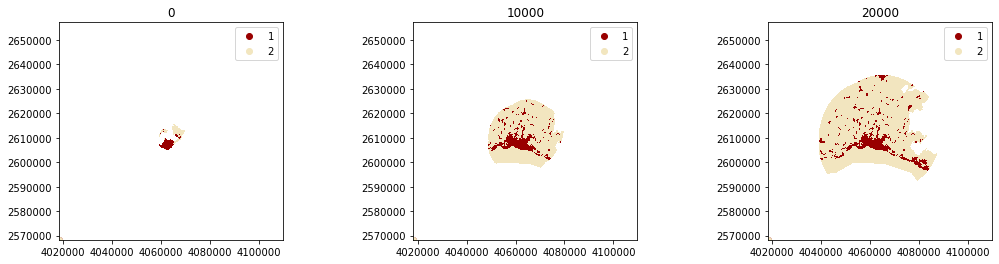

In [26]:
fig = ba.plot_landscapes(cmap=custom_cmap)

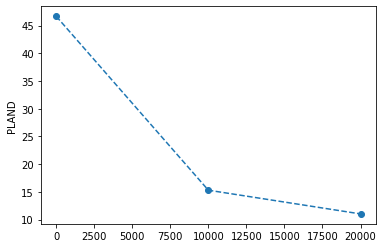

In [27]:
ba.plot_metric('proportion_of_landscape', class_val=URBAN_CLASS_VAL)

## Zonal Grid Analysis

Another recurrent approach to zonal analysis is to decompose the landscape raster into a coarser grid and compute the landscape metrics for each zone cell. This is the purpose of the `ZonalGridAnalysis` class (which also inherits from `ZonalAnalysis`). We can instantiate it by providing the number of landscape pixels that we desire in each zone cell as in:

In [28]:
zone_pixel_width, zone_pixel_height = 50, 50

zga = pls.ZonalGridAnalysis(input_filepath,
                            zone_pixel_width=zone_pixel_width,
                            zone_pixel_height=zone_pixel_height)

Alternatively, we can instead define the number of zones that we desire in each dimension by means of the `num_zone_rows` and `num_zone_cols` keyword arguments of the initialization method.

The `ZonalGridAnalysis` class will automatically discard all the zone cells that have no data in the original raster. We can visualize the zonal grid (in random grid cell colors) as in:

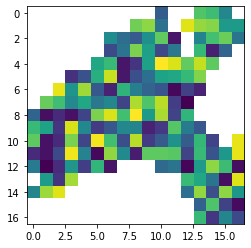

In [29]:
zga.plot_landscapes()

The `compute_class_metrics_df` and `compute_landscape_metrics_df` class operate exactly like in the other classes:

In [30]:
zga.compute_class_metrics_df(metrics=metrics, classes=[URBAN_CLASS_VAL])

metric             proportion_of_landscape edge_density fractal_dimension_am
class_val zones                                                             
1         (0, 10)                      NaN          NaN                  NaN
          (0, 13)                      NaN          NaN                  NaN
          (0, 14)                      NaN          NaN                  NaN
          (0, 15)                  7.55637      7.19074               1.1239
          (1, 8)                       NaN          NaN                  NaN
...                                    ...          ...                  ...
          (15, 16)                     NaN          NaN                  NaN
          (16, 13)                     NaN          NaN                  NaN
          (16, 14)                 14.6364      8.05929              1.09745
          (16, 15)                     NaN          NaN                  NaN
          (16, 16)                     NaN          NaN                  NaN

[174 rows x 3 columns]

Note that the data frames are now indexed by a list of tuples that correspond to the row, column location of each zone. The `NaN` rows thus correspond to zones with no pixels of `URBAN_CLASS_VAL`.

Like in the other zonal analysis classes, the zonal metrics van be represented in space by means of the `compute_zonal_statistics_arr` method. For instance, we can view the spatial distribution of the edge density at the landscape level as in:

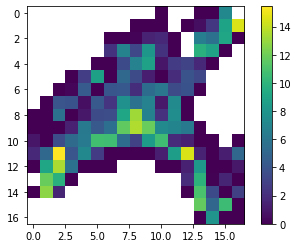

In [31]:
ed_zgs_arr = zga.compute_zonal_statistics_arr('edge_density')

plt.imshow(ed_zgs_arr)
plt.colorbar()

Again, we could provide a file path as the `dst_filepath` argument to dump such result into a raster file.

## See also

* [SpatioTemporalBufferAnalysis](https://github.com/martibosch/pylandstats-notebooks/blob/master/notebooks/05-spatiotemporal-buffer-analysis.ipynb)